In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, classification_report
import shap 
import matplotlib.pyplot as plt
import seaborn as sns

customer_metrics = pd.read_csv('../data/processed/customer_segments.csv')

In [24]:
def prepare_features_for_clv(data):
  features = data.copy()

  features['last_purchase'] = pd.to_datetime(features['last_purchase'])

  features['recency'] = (features['last_purchase'].max() - features['last_purchase']).dt.days

  features['avg_purchase_interval'] = features['customer_lifespan'] / features['order_count']

  features['purchase_regularity'] = features['order_count'] / features['customer_lifespan']

  model_features = ['recency', 'purchase_frequency', 'avg_order_value', 'avg_purchase_interval',              'purchase_regularity']

  return features[model_features]

X = prepare_features_for_clv(customer_metrics)
Y = customer_metrics['total_spend']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


In [25]:
def train_clv_model(X_train, Y_train):
  model = RandomForestRegressor(n_estimators=100, random_state=42)
  model.fit(X_train, Y_train)
  return model

clv_model = train_clv_model(X_train_scaled, Y_train)

train_predictions = clv_model.predict(X_train_scaled)
test_predictions = clv_model.predict(X_test_scaled)

print('CLV Model Performance:')
print(f'Training RMSE {np.sqrt(mean_squared_error(Y_train, train_predictions)):.2f}')
print(f'Testing RMSE {np.sqrt(mean_squared_error(Y_test, test_predictions)):.2f}')

CLV Model Performance:
Training RMSE 2734.78
Testing RMSE 10667.76


In [26]:
def prepare_features_for_churn(data):
  features = data.copy()

  features['last_purchase'] = pd.to_datetime(features['last_purchase'])
  max_date = features['last_purchase'].max()
  features['recency'] = (features['last_purchase'].max() - features['last_purchase']).dt.days
  features['is_churned'] = ((max_date - features['last_purchase']).dt.days > 90)

  features['purchase_trend'] = features['total_spend'] / features['customer_lifespan']
  features['avg_time_between_purchases'] = features['customer_lifespan'] / features['order_count']

  return features

churn_data = prepare_features_for_churn(customer_metrics)
X_churn = churn_data[['recency', 'purchase_frequency', 'avg_order_value', 'purchase_trend',
                      'avg_time_between_purchases']]
Y_churn = churn_data['is_churned']

X_train_churn, X_test_churn, Y_train_churn, Y_test_churn = train_test_split(
  X_churn, Y_churn, test_size=0.2, random_state=42
)

scaler_churn = StandardScaler()
X_train_churn_scaled = scaler_churn.fit_transform(X_train_churn)
X_test_churn_scaled = scaler_churn.transform(X_test_churn)

churn_model = RandomForestClassifier(n_estimators=100, random_state=42)
churn_model.fit(X_train_churn_scaled, Y_train_churn)

print("\nChurn Model Performance:")
print(classification_report(Y_test_churn, 
                          churn_model.predict(X_test_churn_scaled)))


Churn Model Performance:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       561
        True       1.00      1.00      1.00       307

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



c:\Users\ychow\anaconda3\envs\journeyenv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ychow\anaconda3\envs\journeyenv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ychow\anaconda3\envs\journeyenv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


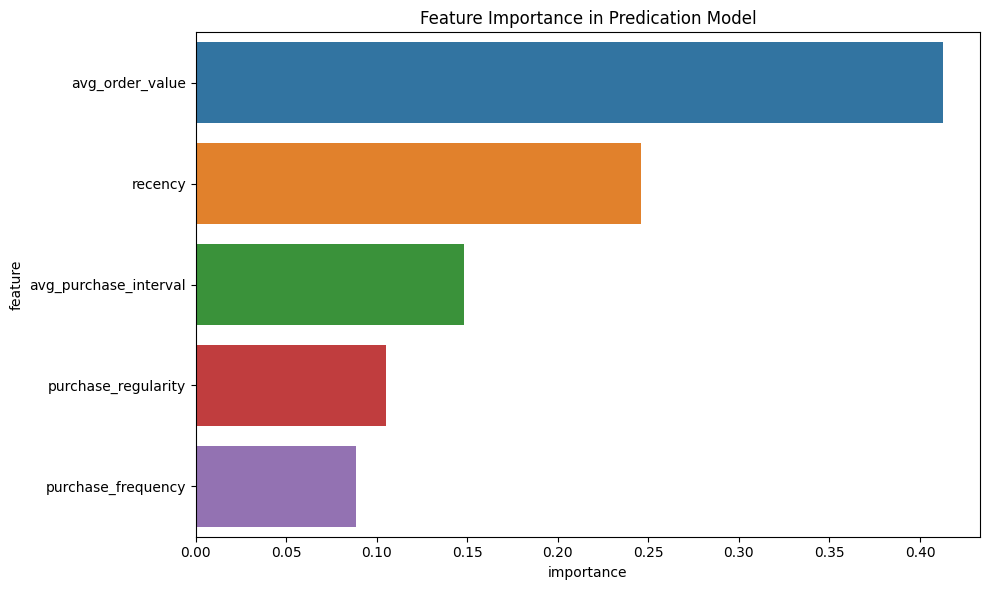

c:\Users\ychow\anaconda3\envs\journeyenv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ychow\anaconda3\envs\journeyenv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ychow\anaconda3\envs\journeyenv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


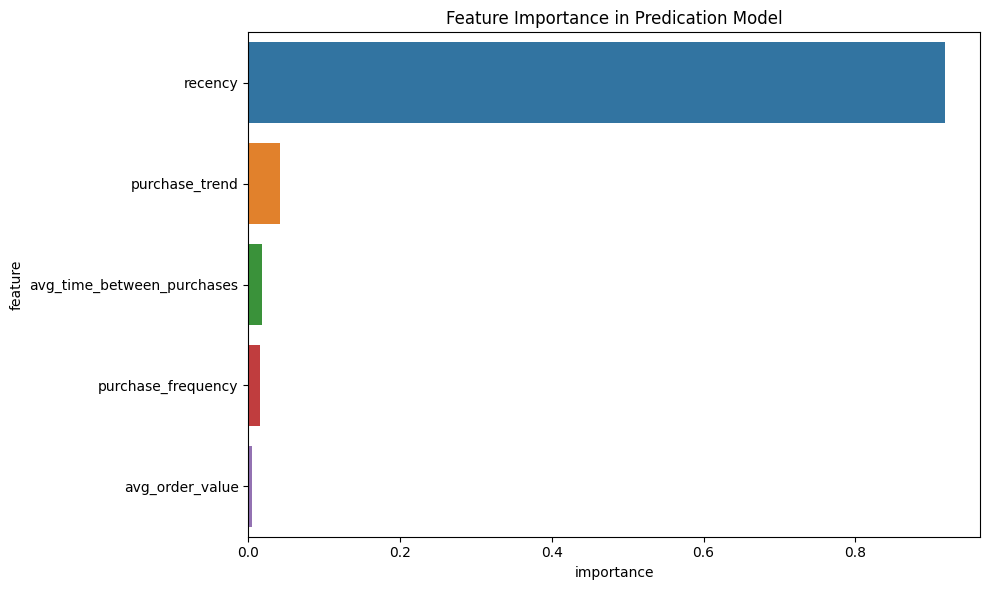

In [27]:
def plot_feature_importance(model, feature_names):
  importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
  })

  plt.figure(figsize=(10, 6))
  sns.barplot(data=importance.sort_values('importance', ascending=False),
              x='importance', y='feature')
  plt.title('Feature Importance in Predication Model')
  plt.tight_layout()
  plt.show()

plot_feature_importance(clv_model, X.columns)
plot_feature_importance(churn_model, X_churn.columns)



In [28]:
customer_metrics['predicted_clv'] = clv_model.predict(scaler.transform(X))
customer_metrics['churn_probability'] = churn_model.predict_proba(
    scaler_churn.transform(X_churn))[:, 1]

In [29]:
customer_metrics.to_csv('../data/processed/customer_predictions.csv', index=False)